In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
import numpy as np
import pathlib
import os

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
PATH = './PokemonData'

data_dir = pathlib.Path(PATH)
classes = os.listdir(PATH)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))

# Number of Pokemon pictures
DATASET_SIZE = len(list(list_ds))

# SETUP
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = len(classes)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

TRAIN_SIZE = int(0.7 * DATASET_SIZE)
EVAL_SIZE = int(0.2 * DATASET_SIZE)
BATCH_SIZE = 32

IMG_HEIGHT = 48
IMG_WIDTH = 48
CHANNELS = 3

## Exploration

We plot the number of images in each class for all 150 classes to see the distribution of data. After plotted the bar chart we found that we have very nicely uniform number of data for every class except for some that has slightly lower number but not much.

<BarContainer object of 150 artists>

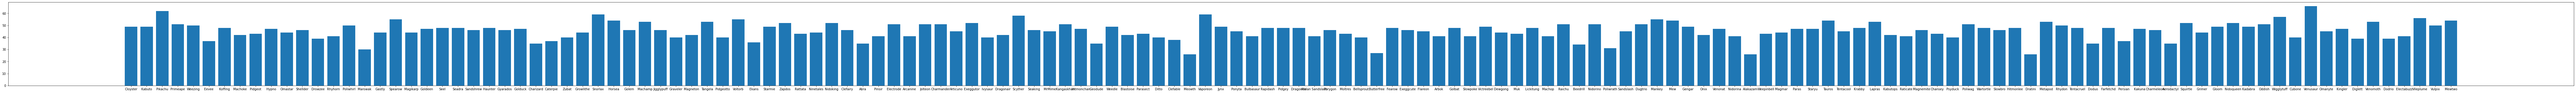

In [4]:
plt.figure(figsize=(150, 5))
plt.bar(classes, [len(os.listdir(PATH + '/' + cls)) for cls in classes])

## Data pre-processing

At this point we read our image and couple with its label for training, evaluation, and testing.

In [5]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def get_label_one_hot(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES


def get_label(file_path):
    return tf.strings.split(file_path, os.path.sep)[-2]
    

def process_path(file_path):
    label = get_label_one_hot(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# Progressive resizing

because our image is a cartoon picture with little detail most of the pixels is just the same color we decided to use **progressive resizing** technique to do transfer learning from lower resolution input to higher resolution input.

On the lower resolution input our network will learn the basic feature such as color and basic shape of the pokemon. After training the lower res network we freeze it and do higher resolution neural network ontop of the previously pre-trained model to learn about more detail feature.

This technique reduce training time a lot and gives equal or better performance than from scratch network.

In [6]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(7,7))
    for n in range(9):
        ax = plt.subplot(3,3,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [7]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [8]:
def modelfit(model, train_set, eval_set, save='trained_default.h5'):
    model.compile(optimizer='adam',
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

    train_batch = TRAIN_SIZE//BATCH_SIZE
    eval_batch = (DATASET_SIZE-TRAIN_SIZE)//BATCH_SIZE

    model.fit(train_set,
                steps_per_epoch=train_batch,
                validation_data=eval_set,
                validation_steps=eval_batch,
                epochs=30,
                verbose=1,
                callbacks=[plot])

    model.save(save)
    
    return model

In [9]:
def load_image():
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

    ds = prepare_for_training(labeled_ds)

    train_ds = ds.take(TRAIN_SIZE)
    eval_ds = ds.skip(TRAIN_SIZE).take(EVAL_SIZE)
    test_ds = ds.skip(TRAIN_SIZE + EVAL_SIZE)

    # Example data with label
    example_batch, example_label_batch = next(iter(train_ds))
    show_batch(example_batch.numpy(), example_label_batch.numpy())
    
    return train_ds, eval_ds, test_ds

## 48 x 48Convultion layers

In [10]:
img_shape=(IMG_HEIGHT, IMG_HEIGHT, 3)

model48 = keras.Sequential()

model48.add(keras.layers.Conv2D(64, 3, input_shape=(img_shape), activation='relu'))
model48.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
model48.add(keras.layers.Dropout(0.2))
model48.add(keras.layers.MaxPool2D())
model48.add(keras.layers.BatchNormalization())

model48.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
model48.add(keras.layers.Dropout(0.2))
model48.add(keras.layers.MaxPool2D())
model48.add(keras.layers.Flatten())
model48.add(keras.layers.Dropout(0.2))

model48.add(keras.layers.Dense(1024, activation='relu'))
model48.add(keras.layers.Dense(512, activation='relu'))
model48.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

model48.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

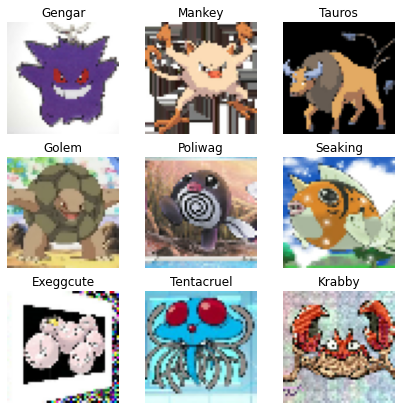

In [11]:
train_ds_48, eval_ds_48, test_ds_48 = load_image()

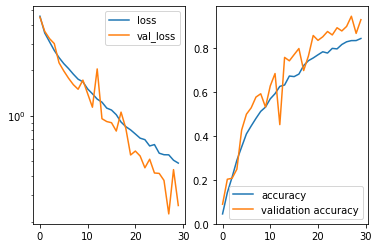

145/145 [==============================] - 4s 27ms/step - loss: 0.4867 - accuracy: 0.8442 - val_loss: 0.2554 - val_accuracy: 0.9299


In [12]:
model48 = modelfit(model48, train_ds_48, eval_ds_48, save='trained_48.h5')

## 96 x 96 Convolutional layers

In [13]:
IMG_HEIGHT = 96
IMG_WIDTH = 96

img_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model96 = keras.Sequential()

model96.add(keras.layers.Conv2D(64, 3, input_shape=(img_shape), activation='relu', padding='same'))
model96.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
model96.add(keras.layers.Dropout(0.2))
model96.add(keras.layers.MaxPool2D(2, 2))

prior = keras.models.load_model('trained_48.h5')

for layer in prior.layers[-12:]:
    layer.trainable = False

for layer in prior.layers[1:]:
    model96.add(layer)

model96.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)       

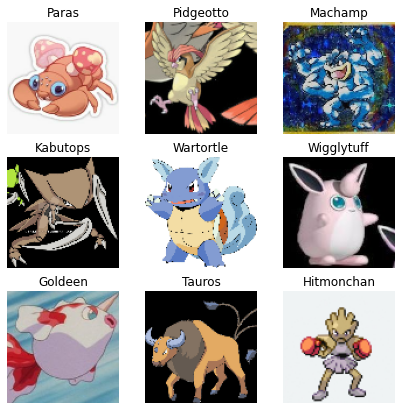

In [14]:
train_ds_96, eval_ds_96, test_ds_96 = load_image()

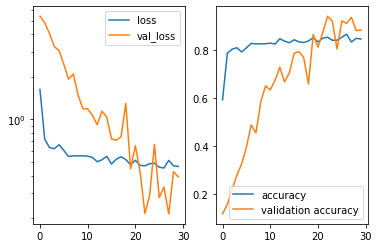

145/145 [==============================] - 14s 96ms/step - loss: 0.4647 - accuracy: 0.8461 - val_loss: 0.3923 - val_accuracy: 0.8836


In [15]:
model96 = modelfit(model96, train_ds_96, eval_ds_96, save='trained_96.h5')

In [16]:
def show_pred_result(image_batch, label_batch, pred):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(top=1.05)
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title("True {0}\nPred: {1}".format(CLASS_NAMES[label_batch[n]==1][0].title(), CLASS_NAMES[pred[n].argmax()]))
        plt.axis('off')

In [17]:
sam_x, sam_y = next(iter(test_ds_96))

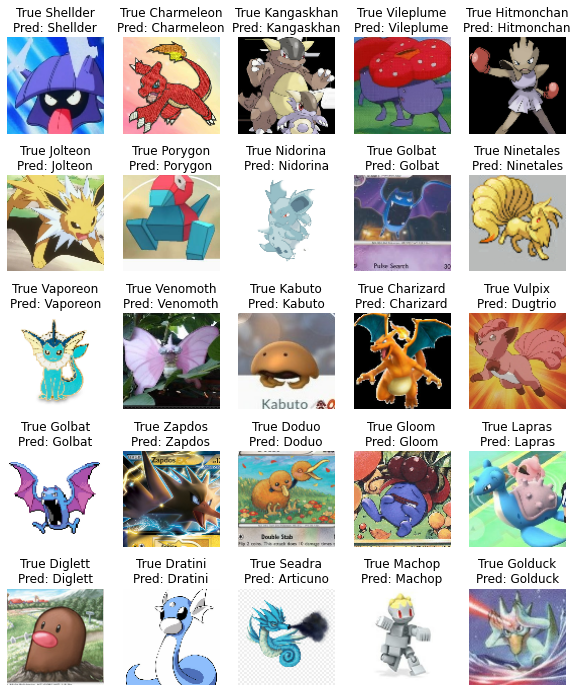

In [18]:
pred = model96.predict(sam_x)

show_pred_result(sam_x.numpy(), sam_y.numpy(), pred)

In [19]:
model = keras.models.load_model('trained_96.h5')

test_iter = iter(test_ds_96)

for i in range(20):
    next_x, next_y = next(test_iter)
    sam_x = tf.concat([sam_x, next_x], 0)
    sam_y = tf.concat([sam_y, next_y], 0)

model.evaluate(sam_x, sam_y, steps=1)

672/672 [==============================] - 3s 5ms/sample - loss: 0.4151 - accuracy: 0.8735


[0.4150843918323517, 0.8735119]

In [20]:
def visualize_layer(in_model, layer_num, img):
    model = keras.Sequential(in_model.layers[: layer_num])
    out = model.predict(np.expand_dims(img, axis=0))
    
    index = 1
    plt.figure(figsize=(15, 15))
    plt.tight_layout()
    for _ in range(8):
        for _ in range(8):
            ax = plt.subplot(8, 8, index)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(out[0, :, :, index - 1], cmap='gray')
            index += 1
            
    plt.show()

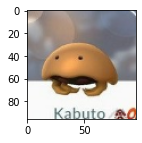

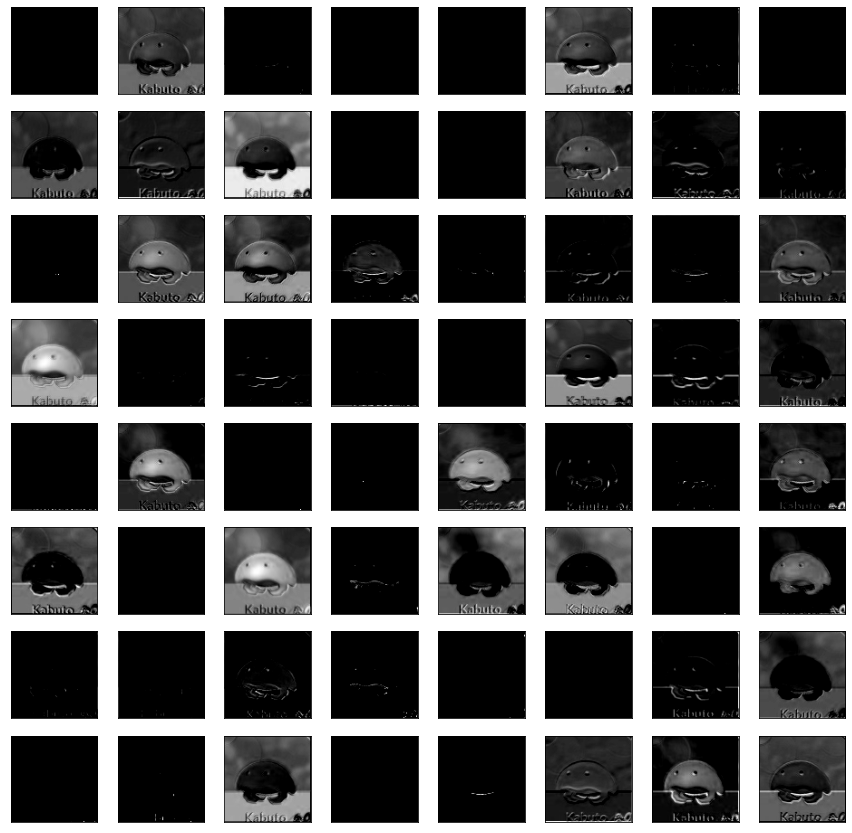

In [21]:
plt.figure(figsize=(2, 2))
plt.imshow(sam_x[12])
visualize_layer(model96, 1, sam_x[12])

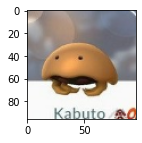

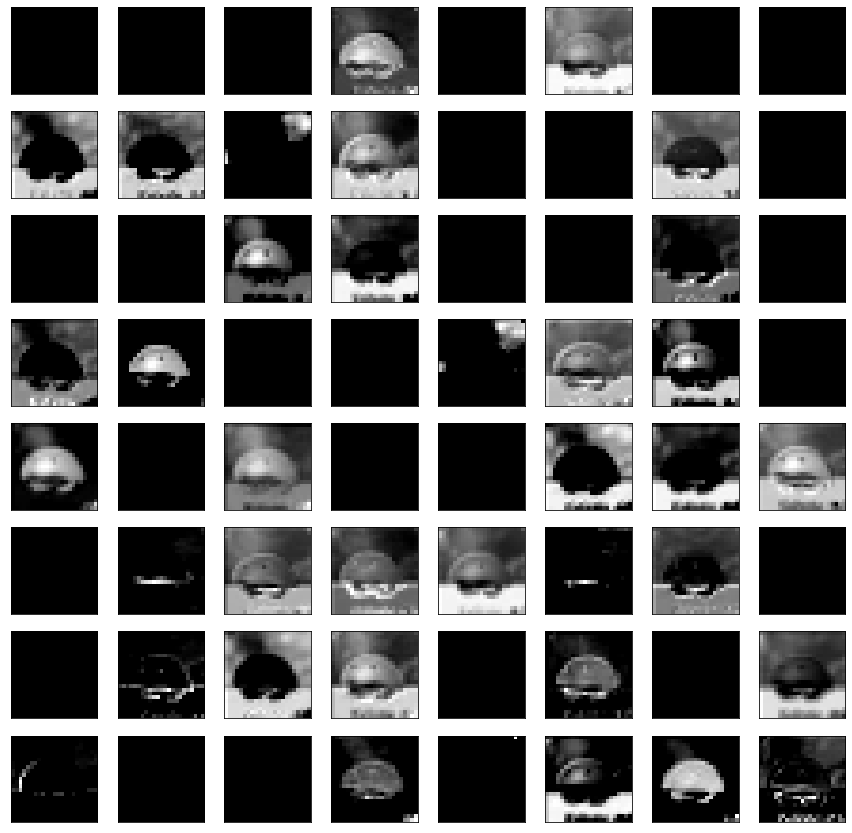

In [22]:
plt.figure(figsize=(2, 2))
plt.imshow(sam_x[12])
visualize_layer(model96, 5, sam_x[12])